# Visualize
Gene expression data in raw gene space vs low dimensional latent space using UMAP

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import random
import glob
import umap
import seaborn as sns
import matplotlib.pyplot as plt

from numpy.random import seed
randomState = 123
seed(randomState)

In [2]:
# Load 
base_dir = os.path.dirname(os.getcwd())
analysis_name = 'sim_balancedAB_2latent'

sim_data_file = os.path.join(
    base_dir,
    "data",
    analysis_name,
    "train_model_input.txt.xz"
)
data_encoded_file = glob.glob(os.path.join(
    base_dir,
    "encoded",
    analysis_name,
    "train_input_2layer_2latent_encoded.txt"))[0]
A_file = os.path.join(
    base_dir,
    "data",
    analysis_name,
    "geneSetA.txt"
)

In [3]:
# Read data
sim_data = pd.read_table(sim_data_file, index_col=0, header=0, compression='xz')
sim_data_encoded = pd.read_table(data_encoded_file, header=0, index_col=0)
geneSetA = pd.read_table(A_file, header=0, index_col=0)

In [4]:
sim_data.head()

,PA3423,PA0084,PA2455,PA3029,PA1588,PA2220,PA4656,PA3585,PA1325,PA3067,...,PA5348,PA4148,PA2158,PA2839,PA2410,PA0090,PA4963,PA3790,PA0969,PA4776
0.1_12hr_CSV86(Pae_G1a).CEL,0.45541,0.45541,0.45541,0.45541,0.45541,0.45541,0.45541,0.45541,0.45541,0.45541,...,0.039832,0.254100,0.30768,0.16118,0.37444,0.64132,0.359890,0.29978,0.47914,0.45004
0.1_2hr_CSV86(Pae_G1a).CEL,0.58208,0.58208,0.58208,0.58208,0.58208,0.58208,0.58208,0.58208,0.58208,0.58208,...,0.349910,0.619100,0.40616,0.23314,0.77043,0.27328,0.065203,0.97198,0.20305,0.29230
0.1_6hr_CSV86(Pae_G1a).CEL,0.24626,0.24626,0.24626,0.24626,0.24626,0.24626,0.24626,0.24626,0.24626,0.24626,...,0.030076,0.031428,0.52120,0.49219,0.52767,0.35445,0.307290,0.38095,0.34503,0.14212
0.1_7hr_CSV86(Pae_G1a).CEL,0.75444,0.75444,0.75444,0.75444,0.75444,0.75444,0.75444,0.75444,0.75444,0.75444,...,0.416210,0.390080,0.45683,0.46744,0.54591,0.47546,0.440540,0.63655,0.42038,0.21466
0.1_9hr_CSV86(Pae_G1a).CEL,0.25606,0.25606,0.25606,0.25606,0.25606,0.25606,0.25606,0.25606,0.25606,0.25606,...,0.022703,0.132680,0.24480,0.44281,0.41727,0.42175,0.214940,0.36677,0.43960,0.26945


In [5]:
sim_data_encoded.head()

,1,2
0.1_12hr_CSV86(Pae_G1a).CEL,0.000000,0.033438
0.1_2hr_CSV86(Pae_G1a).CEL,0.430557,2.364759
0.1_6hr_CSV86(Pae_G1a).CEL,0.000000,0.000000
0.1_7hr_CSV86(Pae_G1a).CEL,0.907591,4.142205
0.1_9hr_CSV86(Pae_G1a).CEL,0.000000,0.000000


In [6]:
geneSetA.head()

,gene id
0,PA3423
1,PA0084
2,PA2455
3,PA3029
4,PA1588


In [7]:
# Label samples by gene A expression

# Since our simulation set all genes in set A to be the same value for a give sample
# we can consider a single gene in set A to query by
rep_gene_A = geneSetA.iloc[0][0]
geneA_exp = sim_data[rep_gene_A]

sample_id = sim_data.index

# Bin gene A expression
geneA_exp_labeled = sim_data.assign(
    rep_geneA=(
        list( 
            map(
                lambda x:
                '1' if 0 < x and x <=0.1 
                else '2' if 0.1< x and x <=0.2 
                else '3' if 0.2<x and x<=0.3
                else '4' if 0.3<x  and x<=0.4
                else '5' if 0.4<x and x<=0.5
                else '6' if 0.5<x and x<=0.6
                else '7' if 0.6<x and x<=0.7
                else '8' if 0.7<x and x<=0.8
                else '9' if 0.8<x and x<=0.9
                else '10',
                geneA_exp
            )      
        )
    )
)
geneA_exp_labeled = geneA_exp_labeled.astype({"rep_geneA": int})
geneA_exp_labeled.head()

,PA3423,PA0084,PA2455,PA3029,PA1588,PA2220,PA4656,PA3585,PA1325,PA3067,...,PA4148,PA2158,PA2839,PA2410,PA0090,PA4963,PA3790,PA0969,PA4776,rep_geneA
0.1_12hr_CSV86(Pae_G1a).CEL,0.45541,0.45541,0.45541,0.45541,0.45541,0.45541,0.45541,0.45541,0.45541,0.45541,...,0.254100,0.30768,0.16118,0.37444,0.64132,0.359890,0.29978,0.47914,0.45004,5
0.1_2hr_CSV86(Pae_G1a).CEL,0.58208,0.58208,0.58208,0.58208,0.58208,0.58208,0.58208,0.58208,0.58208,0.58208,...,0.619100,0.40616,0.23314,0.77043,0.27328,0.065203,0.97198,0.20305,0.29230,6
0.1_6hr_CSV86(Pae_G1a).CEL,0.24626,0.24626,0.24626,0.24626,0.24626,0.24626,0.24626,0.24626,0.24626,0.24626,...,0.031428,0.52120,0.49219,0.52767,0.35445,0.307290,0.38095,0.34503,0.14212,3
0.1_7hr_CSV86(Pae_G1a).CEL,0.75444,0.75444,0.75444,0.75444,0.75444,0.75444,0.75444,0.75444,0.75444,0.75444,...,0.390080,0.45683,0.46744,0.54591,0.47546,0.440540,0.63655,0.42038,0.21466,8
0.1_9hr_CSV86(Pae_G1a).CEL,0.25606,0.25606,0.25606,0.25606,0.25606,0.25606,0.25606,0.25606,0.25606,0.25606,...,0.132680,0.24480,0.44281,0.41727,0.42175,0.214940,0.36677,0.43960,0.26945,3


## Plot gene expression in gene space

Each dot is a sample.  Each sample is colored based on its expression of gene A

In the legend 1 ~ gene A expression is (0.0, 0.1], 2 ~ gene A expression is (0.1, 0.2], etc.

In [8]:
# UMAP embedding of raw gene space data
embedding = umap.UMAP().fit_transform(sim_data)
embedding.shape

(1191, 2)

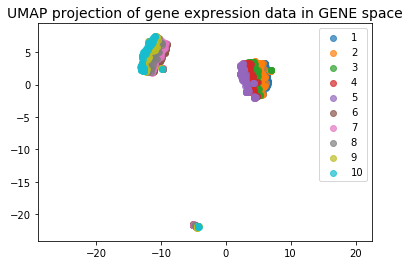

In [9]:
# UMAP plot of raw gene expression data
geneA_exp_labeled = geneA_exp_labeled.assign(sample_index=list(range(geneA_exp_labeled.shape[0])))
for x in geneA_exp_labeled.rep_geneA.sort_values().unique():
    plt.scatter(
        embedding[geneA_exp_labeled.query("rep_geneA == @x").sample_index.values, 0], 
        embedding[geneA_exp_labeled.query("rep_geneA == @x").sample_index.values, 1], 
        c=sns.color_palette()[x-1],
        alpha=0.7,
        label=str(x)
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of gene expression data in GENE space', fontsize=14)
plt.legend()

## Plot gene expression in VAE encoded latent space

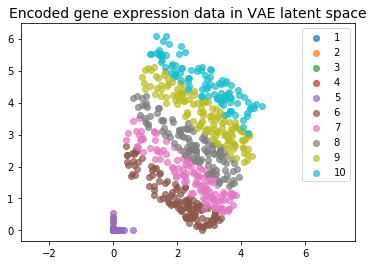

In [10]:
# Plot of gene expression data in VAE latent space
geneA_exp_labeled = geneA_exp_labeled.assign(sample_index=list(range(geneA_exp_labeled.shape[0])))
for x in geneA_exp_labeled.rep_geneA.sort_values().unique():
    sample_ids = list(geneA_exp_labeled.query("rep_geneA == @x").sample_index.index)
    plt.scatter(
        sim_data_encoded.loc[sample_ids, '1'], 
        sim_data_encoded.loc[sample_ids, '2'], 
        c=sns.color_palette()[x-1],
        alpha=0.7,
        label=str(x)
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Encoded gene expression data in VAE latent space', fontsize=14)
plt.legend()

In [11]:
# UMAP embedding of VAE encoded gene space data
embedding_encoded = umap.UMAP().fit_transform(sim_data_encoded)
embedding_encoded.shape

/home/alexandra/anaconda3/envs/Pa/lib/python3.5/site-packages/umap/spectral.py:229: UserWarning: Embedding 2 connected components using meta-embedding (experimental)
  n_components


(1191, 2)

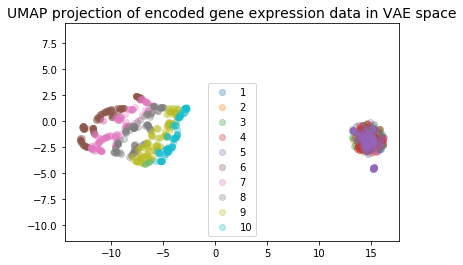

In [12]:
# UMAP plot of raw gene expression data
geneA_exp_labeled = geneA_exp_labeled.assign(sample_index=list(range(geneA_exp_labeled.shape[0])))
for x in geneA_exp_labeled.rep_geneA.sort_values().unique():
    plt.scatter(
        embedding_encoded[geneA_exp_labeled.query("rep_geneA == @x").sample_index.values, 0], 
        embedding_encoded[geneA_exp_labeled.query("rep_geneA == @x").sample_index.values, 1], 
        c=sns.color_palette()[x-1],
        alpha=0.3,
        label=str(x)
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of encoded gene expression data in VAE space', fontsize=14)
plt.legend()